<a href="https://colab.research.google.com/github/AyishaR/Spokendigit/blob/master/Spokendigit_Five_features.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
from torch.utils.data import Dataset, random_split, DataLoader, TensorDataset
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import tarfile
import os
import librosa
import pandas as pd
import numpy as np
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import librosa.display
import sklearn
import matplotlib
import csv
from PIL import Image
from tqdm.notebook import tqdm
from sklearn.metrics import f1_score

#Data

In [ ]:
digit = ['zero', 'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine']

#Dataset 



Spoken_mnist_finalfts.csv is generated in 'Spokenmnist feature extraction.ipynb'.

In [ ]:
finalfts = pd.read_csv("Spoken_digit_finalfts.csv")

In [ ]:
from sklearn.preprocessing import StandardScaler
scale = StandardScaler()
finalfts[finalfts.columns[1:]] = scale.fit_transform(finalfts[finalfts.columns[1:]])

In [ ]:
spokendset = TensorDataset(torch.tensor(np.array(finalfts[finalfts.columns[1:]].astype('float32'))),torch.tensor(finalfts['Label'])) 

In [ ]:
# 90-10 split
size = len(spokendset)
val_size = int(0.1 * size)
train_size = size - val_size 

train_dset, val_dset = random_split(spokendset, [train_size, val_size])

train_size, val_size

(21298, 2366)

In [ ]:
train_dl = DataLoader(train_dset, 512, True)
val_dl = DataLoader(val_dset, 512)

# Device


In [ ]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        return len(self.dl)

In [ ]:
device = get_default_device()
device

device(type='cpu')

In [ ]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)

#Train

In [ ]:
class SpokenDigitModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.l1 = nn.Linear(173, 1024)
        self.l2 = nn.Linear(1024, 512)
        self.l3 = nn.Linear(512, 64)
        self.l4 = nn.Linear(64, 10)

    def forward(self, x):
        x = F.relu(self.l1(x))
        x = F.relu(self.l2(x))
        x = F.relu(self.l3(x))
        x = self.l4(x)
        return x

    def training_step(self, batch):
        inputs, labels = batch
        outputs = self(inputs)
        loss = F.cross_entropy(outputs, labels)
        return loss

    def validation_step(self, batch):
        inputs, labels = batch
        outputs = self(inputs)
        loss = F.cross_entropy(outputs, labels)
        _, pred = torch.max(outputs, 1)
        accuracy = torch.tensor(torch.sum(pred==labels).item()/len(pred))
        return [loss.detach(), accuracy.detach()] 

In [ ]:
def evaluate(model, loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in loader]
    outputs = torch.tensor(outputs).T
    loss, accuracy = torch.mean(outputs, dim=1)
    return {"loss" : loss.item(), "accuracy" : accuracy.item()}

In [ ]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

In [ ]:
def fit(model, train_loader, val_loader, epochs, lr, optimizer_function = torch.optim.Adam):
    history = []
    optimizer = optimizer_function(model.parameters(), lr)
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, lr, epochs=epochs, steps_per_epoch=len(train_loader))
    for epoch in range(epochs):
        print("Epoch ", epoch)
        #Train
        model.train()
        lrs = []
        tr_loss = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            tr_loss.append(loss)
            loss.backward()

            optimizer.step()
            optimizer.zero_grad()
            lrs.append(get_lr(optimizer))
            sched.step()
        #Validate
        result = evaluate(model, val_loader)
        result["lrs"] = lrs
        result["train loss"] = torch.stack(tr_loss).mean().item()
 
        print("Last lr: ", lrs[-1]," Train_loss: ", result["train loss"], " Val_loss: ", result['loss'], " Accuracy: ", result['accuracy'])
        history.append(result)         
    return history

In [ ]:
model = to_device(SpokenDigitModel(), device)
history = []
evaluate(model, val_dl)

{'accuracy': 0.10285229980945587, 'loss': 3.1926627159118652}

In [ ]:
history.append(fit(model, train_dl, val_dl, 64, 0.01))

Epoch  0



Last lr:  0.00046125331558460707  Train_loss:  2.2663004398345947  Val_loss:  1.9734230041503906  Accuracy:  0.2775648534297943
Epoch  1



Last lr:  0.000649371685235026  Train_loss:  1.7904225587844849  Val_loss:  1.602102518081665  Accuracy:  0.4390698969364166
Epoch  2



Last lr:  0.0009593538973555506  Train_loss:  1.523494839668274  Val_loss:  1.4762526750564575  Accuracy:  0.4833161234855652
Epoch  3



Last lr:  0.0013828987634391283  Train_loss:  1.409789800643921  Val_loss:  1.388493299484253  Accuracy:  0.507468581199646
Epoch  4



Last lr:  0.0019086639366120376  Train_loss:  1.3067811727523804  Val_loss:  1.312547206878662  Accuracy:  0.5427034497261047
Epoch  5



Last lr:  0.0025225696547385964  Train_loss:  1.2852962017059326  Val_loss:  1.3043409585952759  Accuracy:  0.535328209400177
Epoch  6



Last lr:  0.0032081757903132157  Train_loss:  1.2174406051635742  Val_loss:  1.2921302318572998  Accuracy:  0.562539279460907
Epoch  7



Last lr:  0.003947122109908103  Train_loss:  1.1247762441635132  Val_loss:  1.1220277547836304  Accuracy:  0.6068248748779297
Epoch  8



Last lr:  0.004719619953220507  Train_loss:  1.0825754404067993  Val_loss:  1.1073895692825317  Accuracy:  0.6051100492477417
Epoch  9



Last lr:  0.0055049821647689574  Train_loss:  1.0380043983459473  Val_loss:  1.136926293373108  Accuracy:  0.6121217012405396
Epoch  10



Last lr:  0.006282177086898712  Train_loss:  1.045823097229004  Val_loss:  1.057567834854126  Accuracy:  0.6328641176223755
Epoch  11



Last lr:  0.0070303917784052174  Train_loss:  1.0040557384490967  Val_loss:  1.1139905452728271  Accuracy:  0.6073604822158813
Epoch  12



Last lr:  0.007729589376026378  Train_loss:  0.9714570045471191  Val_loss:  1.1389217376708984  Accuracy:  0.5997002720832825
Epoch  13



Last lr:  0.008361045672905848  Train_loss:  0.951012372970581  Val_loss:  1.0961071252822876  Accuracy:  0.6319305300712585
Epoch  14



Last lr:  0.00890785054469004  Train_loss:  1.0314011573791504  Val_loss:  1.1321548223495483  Accuracy:  0.6216022968292236
Epoch  15



Last lr:  0.009355360795286486  Train_loss:  0.9443890452384949  Val_loss:  1.1194788217544556  Accuracy:  0.6296457052230835
Epoch  16



Last lr:  0.009691592295271681  Train_loss:  0.9036546349525452  Val_loss:  1.063692331314087  Accuracy:  0.6589425802230835
Epoch  17



Last lr:  0.009907540911652659  Train_loss:  0.8656073212623596  Val_loss:  1.0020185708999634  Accuracy:  0.6790561079978943
Epoch  18



Last lr:  0.009997423634623305  Train_loss:  0.8594816327095032  Val_loss:  1.0414087772369385  Accuracy:  0.6686885952949524
Epoch  19



Last lr:  0.009992134106552784  Train_loss:  0.8173950910568237  Val_loss:  0.9999626278877258  Accuracy:  0.6641730070114136
Epoch  20



Last lr:  0.009960221326213456  Train_loss:  0.7832161784172058  Val_loss:  1.0241364240646362  Accuracy:  0.6692241430282593
Epoch  21



Last lr:  0.009903926786310545  Train_loss:  0.7532407641410828  Val_loss:  1.0551531314849854  Accuracy:  0.6791027784347534
Epoch  22



Last lr:  0.009823527201405897  Train_loss:  0.7301464676856995  Val_loss:  1.1082905530929565  Accuracy:  0.6410598754882812
Epoch  23



Last lr:  0.009719417773875232  Train_loss:  0.6775733232498169  Val_loss:  0.999755859375  Accuracy:  0.6905955076217651
Epoch  24



Last lr:  0.009592110251299626  Train_loss:  0.6622872352600098  Val_loss:  0.9950535893440247  Accuracy:  0.6990369558334351
Epoch  25



Last lr:  0.009442230410981642  Train_loss:  0.6298896074295044  Val_loss:  1.041617751121521  Accuracy:  0.6877358555793762
Epoch  26



Last lr:  0.009270514983950873  Train_loss:  0.5943053364753723  Val_loss:  1.2047443389892578  Accuracy:  0.6444698572158813
Epoch  27



Last lr:  0.009077808033578922  Train_loss:  0.6184790730476379  Val_loss:  1.0271871089935303  Accuracy:  0.7015796899795532
Epoch  28



Last lr:  0.008865056806604618  Train_loss:  0.5867840647697449  Val_loss:  1.0423036813735962  Accuracy:  0.7040290832519531
Epoch  29



Last lr:  0.008633307076963694  Train_loss:  0.590764045715332  Val_loss:  1.0807956457138062  Accuracy:  0.706611156463623
Epoch  30



Last lr:  0.00838369800531021  Train_loss:  0.545917809009552  Val_loss:  1.1036874055862427  Accuracy:  0.7169393301010132
Epoch  31



Last lr:  0.00811745653949763  Train_loss:  0.5054436326026917  Val_loss:  1.0003987550735474  Accuracy:  0.7195214033126831
Epoch  32



Last lr:  0.007835891383543871  Train_loss:  0.4925272762775421  Val_loss:  1.0893977880477905  Accuracy:  0.6974548101425171
Epoch  33



Last lr:  0.007540386564725742  Train_loss:  0.4661272168159485  Val_loss:  1.1357347965240479  Accuracy:  0.7088222503662109
Epoch  34



Last lr:  0.007232394630423575  Train_loss:  0.44089603424072266  Val_loss:  1.0833054780960083  Accuracy:  0.723884642124176
Epoch  35



Last lr:  0.006913429508156801  Train_loss:  0.41059574484825134  Val_loss:  1.198183298110962  Accuracy:  0.7159198522567749
Epoch  36



Last lr:  0.006585059063906823  Train_loss:  0.4195560812950134  Val_loss:  1.1603243350982666  Accuracy:  0.7264003753662109
Epoch  37



Last lr:  0.006248897395306571  Train_loss:  0.3858809173107147  Val_loss:  1.1935256719589233  Accuracy:  0.729849636554718
Epoch  38



Last lr:  0.0059065968975793946  Train_loss:  0.346382200717926  Val_loss:  1.1201636791229248  Accuracy:  0.731087863445282
Epoch  39



Last lr:  0.005559840141227017  Train_loss:  0.32186922430992126  Val_loss:  1.3665460348129272  Accuracy:  0.7242752313613892
Epoch  40



Last lr:  0.005210331601391554  Train_loss:  0.3209773600101471  Val_loss:  1.3166067600250244  Accuracy:  0.73008793592453
Epoch  41



Last lr:  0.00485978927954578  Train_loss:  0.26930490136146545  Val_loss:  1.413875699043274  Accuracy:  0.740548849105835
Epoch  42



Last lr:  0.004509936258695003  Train_loss:  0.2427389919757843  Val_loss:  1.3798919916152954  Accuracy:  0.743455171585083
Epoch  43



Last lr:  0.004162492233600785  Train_loss:  0.21230579912662506  Val_loss:  1.385957956314087  Accuracy:  0.739072322845459
Epoch  44



Last lr:  0.0038191650576594933  Train_loss:  0.1948038786649704  Val_loss:  1.4249134063720703  Accuracy:  0.7524788975715637
Epoch  45



Last lr:  0.003481642347986829  Train_loss:  0.17658202350139618  Val_loss:  1.5488786697387695  Accuracy:  0.7417600154876709
Epoch  46



Last lr:  0.0031515831899733408  Train_loss:  0.16266420483589172  Val_loss:  1.547590970993042  Accuracy:  0.750486433506012
Epoch  47



Last lr:  0.0028306099820869924  Train_loss:  0.14839866757392883  Val_loss:  1.6638180017471313  Accuracy:  0.7478847503662109
Epoch  48



Last lr:  0.0025203004610094945  Train_loss:  0.14014747738838196  Val_loss:  1.7248947620391846  Accuracy:  0.747361421585083
Epoch  49



Last lr:  0.002222179946306651  Train_loss:  0.12502115964889526  Val_loss:  1.7559407949447632  Accuracy:  0.7515919804573059
Epoch  50



Last lr:  0.0019377138427538756  Train_loss:  0.10473035275936127  Val_loss:  1.787615180015564  Accuracy:  0.7557561993598938
Epoch  51



Last lr:  0.0016683004371715396  Train_loss:  0.09393233805894852  Val_loss:  1.8428767919540405  Accuracy:  0.7527638673782349
Epoch  52



Last lr:  0.0014152640251771198  Train_loss:  0.08405303210020065  Val_loss:  1.8900619745254517  Accuracy:  0.7617015242576599
Epoch  53



Last lr:  0.001179848401639479  Train_loss:  0.07771271467208862  Val_loss:  1.8915631771087646  Accuracy:  0.7528498768806458
Epoch  54



Last lr:  0.000963210746832791  Train_loss:  0.07058475911617279  Val_loss:  1.9309871196746826  Accuracy:  0.7554318904876709
Epoch  55



Last lr:  0.0007664159383425639  Train_loss:  0.06618408113718033  Val_loss:  1.9533334970474243  Accuracy:  0.7583382725715637
Epoch  56



Last lr:  0.0005904313166835123  Train_loss:  0.0635305717587471  Val_loss:  1.9677464962005615  Accuracy:  0.7633500099182129
Epoch  57



Last lr:  0.0004361219303587067  Train_loss:  0.0610000304877758  Val_loss:  1.995688796043396  Accuracy:  0.7587288618087769
Epoch  58



Last lr:  0.0003042462837328597  Train_loss:  0.05950706824660301  Val_loss:  1.995245337486267  Accuracy:  0.7577952742576599
Epoch  59



Last lr:  0.00019545260862094147  Train_loss:  0.0577256977558136  Val_loss:  2.0072267055511475  Accuracy:  0.7595101594924927
Epoch  60



Last lr:  0.00011027567791908655  Train_loss:  0.056645650416612625  Val_loss:  2.016090154647827  Accuracy:  0.7627211213111877
Epoch  61



Last lr:  4.913417694027851e-05  Train_loss:  0.05607904866337776  Val_loss:  2.019317150115967  Accuracy:  0.7623304724693298
Epoch  62



Last lr:  1.232864537599174e-05  Train_loss:  0.05574125424027443  Val_loss:  2.0201499462127686  Accuracy:  0.7615492343902588
Epoch  63



Last lr:  4e-08  Train_loss:  0.055521465837955475  Val_loss:  2.0203850269317627  Accuracy:  0.7619398832321167


In [ ]:
@torch.no_grad()
def predict_dl(model, dl):
    torch.cuda.empty_cache()
    batch_probs = []
    batch_targ = []
    for xb, yb in dl:
        probs = model(xb)
        batch_probs.append(probs.cpu().detach())
        batch_targ.append(yb.cpu().detach())
    batch_probs = torch.cat(batch_probs)
    batch_targ = torch.cat(batch_targ)
    return [list(values).index(max(values)) for values in batch_probs], batch_targ

In [39]:
r = evaluate(model, val_dl)
yp, yt = predict_dl(model, val_dl)
print("Loss: ", r['loss'], "\nAccuracy: ", r['accuracy'], "\nF-score: ", f1_score(yt, yp, average='micro'))

Loss:  2.0203850269317627 
Accuracy:  0.7619398832321167 
F-score:  0.7586644125105664


In [ ]:
torch.save(model, '/content/spokendigit_lr_all.pth')

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type SpokenDigitModel. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [40]:
losses = []
accuracies = []
last_lr = []
for i in history[0]:
    losses.append(i['loss'])
    accuracies.append(i['accuracy'])
    last_lr.append(i['lrs'][-1])

def plot(var, title):
    plt.plot(var, '-x')
    plt.title(title)

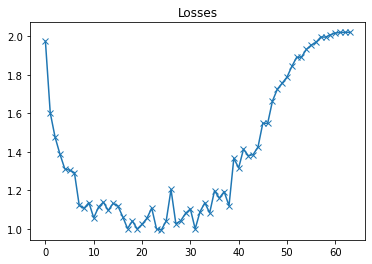

In [41]:
plot(losses, 'Losses')

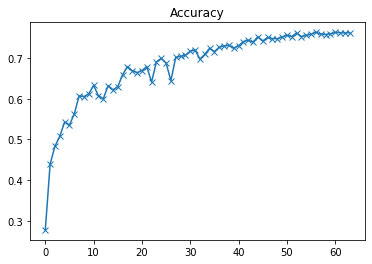

In [42]:
plot(accuracies, 'Accuracy')

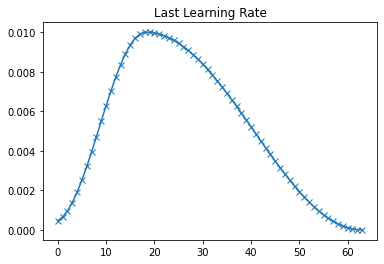

In [43]:
plot(last_lr, 'Last Learning Rate')